Ce projet analyse les données de ventes retail pour identifier les leviers d'optimisation business. Nous utiliserons une approche par types de magasins pour extraire des insights actionnables sur les stratégies d'assortiment départemental.

# Importation

Nous commençons par importer les bibliothèques nécessaires pour ce projet.

In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os
import plotly.express as px
import plotly.graph_objects as go

Nous chargeons les datasets depuis les fichiers CSV.

In [3]:
# Chargement des données
stores_df = pd.read_csv("D:/projet_retail/stores.csv")
features_df = pd.read_csv("D:/projet_retail/features.csv")
sales_df = pd.read_csv("D:/projet_retail/sales.csv")

print("Données brutes chargées:")
print(f"Stores: {stores_df.shape}")
print(f"Features: {features_df.shape}")
print(f"Sales: {sales_df.shape}")

Données brutes chargées:
Stores: (45, 3)
Features: (8190, 12)
Sales: (421570, 5)


Nous créons la connexion à la base SQLite pour nos analyses.

In [4]:
# Création base SQLite
conn = sqlite3.connect("retail.db")

# Nettoyage

## Nettoyage et standardisation

Standardisation des formats, gestion des valeurs manquantes et préparation des données pour l'analyse.

In [5]:
# Nettoyage Stores
stores_clean = stores_df.dropna(subset=['Store'])

# Nettoyage Features  
features_clean = features_df.copy()
features_clean['Date'] = pd.to_datetime(features_clean['Date'], dayfirst=True)

# Standardisation MarkDown
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in features_clean.columns:
        features_clean[col] = features_clean[col].replace(['NA', ''], pd.NA)
        features_clean[col] = pd.to_numeric(features_clean[col], errors='coerce')

# Standardisation IsHoliday 
if 'IsHoliday' in features_clean.columns:
    features_clean['IsHoliday'] = features_clean['IsHoliday'].map({
        True: 1, False: 0, 'TRUE': 1, 'FALSE': 0
    })

features_clean = features_clean.dropna(subset=['Store', 'Date', 'Temperature', 'Fuel_Price'])

# Nettoyage Sales
sales_clean = sales_df.copy()
sales_clean['Date'] = pd.to_datetime(sales_clean['Date'], dayfirst=True)

if 'IsHoliday' in sales_clean.columns:
    sales_clean['IsHoliday'] = sales_clean['IsHoliday'].map({
        True: 1, False: 0, 'TRUE': 1, 'FALSE': 0
    })

sales_clean = sales_clean.dropna(subset=['Store', 'Dept', 'Date', 'Weekly_Sales'])

print("Nettoyage terminé:")
print(f"Stores: {len(stores_clean)} lignes")
print(f"Features: {len(features_clean)} lignes") 
print(f"Sales: {len(sales_clean)} lignes")



stores_clean.to_csv('stores_clean.csv', index=False)
features_clean.to_csv('features_clean.csv', index=False) 
sales_clean.to_csv('sales_clean.csv', index=False)

Nettoyage terminé:
Stores: 45 lignes
Features: 8190 lignes
Sales: 421570 lignes


Nous créer des _clean.csv pour qu'ils soient utilisés plus tard dans le streamlit.

## Sauvegarde des données nettoyées

Nous sauvegardons les données nettoyées en SQLite pour les analyses.

In [6]:
# Sauvegarde en SQL
stores_clean.to_sql('stores', conn, if_exists='replace', index=False)
features_clean.to_sql('features', conn, if_exists='replace', index=False) 
sales_clean.to_sql('sales', conn, if_exists='replace', index=False)

conn.commit()

Nous allons maintenant pouvoir passer à l'analyse des données.

# Analyse

## KPI Fondamentaux

Nous commençons les analyses par le calcul des principaux KPI

In [7]:
# KPI Globaux
query = """
SELECT 
    ROUND(SUM(Weekly_Sales), 2) AS CA_Total,
    ROUND(AVG(Weekly_Sales), 2) AS CA_Moyen,
    COUNT(*) AS Total_Observations,
    COUNT(DISTINCT Store) AS Nb_Magasins,
    COUNT(DISTINCT Dept) AS Nb_Departements,
    MIN(DATE(Date)) AS Date_Debut,
    MAX(DATE(Date)) AS Date_Fin
FROM sales;
"""

kpi_globaux = pd.read_sql(query, conn)
print(kpi_globaux)

       CA_Total  CA_Moyen  Total_Observations  Nb_Magasins  Nb_Departements  \
0  6.737219e+09  15981.26              421570           45               81   

   Date_Debut    Date_Fin  
0  2010-02-05  2012-10-26  


## Impact des promotions

Nous avons remarqué qu'il y avait une variable promotions dans les données, nous allons donc voir si celle-ci peut être utile.

In [8]:
# Analyse impact promotions
query_promotions = """
SELECT 
    CASE 
        WHEN (COALESCE(f.MarkDown1, 0) + COALESCE(f.MarkDown2, 0) + 
              COALESCE(f.MarkDown3, 0) + COALESCE(f.MarkDown4, 0) + 
              COALESCE(f.MarkDown5, 0)) > 0 THEN 'Avec Promo'
        ELSE 'Sans Promo'
    END AS Statut_Promo,
    COUNT(*) as Nb_Observations,
    ROUND(AVG(sa.Weekly_Sales), 2) AS CA_Moyen
FROM features f
JOIN sales sa ON f.Store = sa.Store AND f.Date = sa.Date
GROUP BY Statut_Promo;
"""

promo_impact = pd.read_sql(query_promotions, conn)
print(promo_impact)

  Statut_Promo  Nb_Observations  CA_Moyen
0   Avec Promo           151432  16177.02
1   Sans Promo           270138  15871.52


Nous remarquons que les promotions n'ont pas un impact significatif, nous ne poussons pas les analyses plus loin.

## Analyse des magasins et validation typologie

De même, nous avons la varibales type, nous allons compararé la taille ainsi que les CA hebdo. des différents type.

In [9]:
# Validation typologie ABC
query_types = """
SELECT 
    s.Type,
    COUNT(DISTINCT s.Store) AS Nb_Magasins,
    ROUND(AVG(s.Size), 0) AS Taille_Moyenne,
    ROUND(AVG(sa.Weekly_Sales), 2) AS CA_Moyen
FROM sales sa
JOIN stores s ON sa.Store = s.Store
GROUP BY s.Type
ORDER BY Taille_Moyenne DESC;
"""

types_validation = pd.read_sql(query_types, conn)
print(types_validation)

  Type  Nb_Magasins  Taille_Moyenne  CA_Moyen
0    A           22        182231.0  20099.57
1    B           17        101819.0  12237.08
2    C            6         40536.0   9519.53


Nous avons donc bien un lien entre la taille et le CA , ce que était attendu, de plus on se retourve avec un classication A = Grand magasin, B = Moyen magasin , C = Petit magasin.

## Analyse de la période temporelle

Nous allons maintenant vérifier les données temporelles. Pour cela nous commençons par regardé les nombres d'obeservations par mois pour pouvoir ensuite faire une pondérations par leurs nombres si necessaire.

In [10]:
# Période des données
premiere_date = sales_clean['Date'].min()
derniere_date = sales_clean['Date'].max()

print(f"Première date: {premiere_date.strftime('%d/%m/%Y')}")
print(f"Dernière date: {derniere_date.strftime('%d/%m/%Y')}")

# Analyse des variations mensuelles
monthly_counts = sales_clean.groupby(sales_clean['Date'].dt.month).size()
for month in sorted(monthly_counts.index):
    print(f"Mois {month:2d}: {monthly_counts[month]:6,} observations")



Première date: 05/02/2010
Dernière date: 26/10/2012
Mois  1: 23,545 observations
Mois  2: 35,526 observations
Mois  3: 38,451 observations
Mois  4: 41,332 observations
Mois  5: 35,314 observations
Mois  6: 38,137 observations
Mois  7: 40,980 observations
Mois  8: 38,169 observations
Mois  9: 38,339 observations
Mois 10: 38,362 observations
Mois 11: 23,613 observations
Mois 12: 29,802 observations


Nous remarquons une différence de près de 100% entre les différents mois, nous allons devoir pondérer les analyses par le nombre d'observations par mois si nous voulons faire des analyses temporelles. Ce que nous ferons plus tard.

## Analyse départementale par type

Nous souhaitons comprendre comment se structurent les magasins des différents types, pour cela nous allons analyser les meilleurs départements des différents types de magasins.

In [11]:

query_dept_stars = """
SELECT 
    s.Type,
    sa.Dept,
    ROUND(SUM(sa.Weekly_Sales), 2) AS CA_Total,
    ROUND(AVG(sa.Weekly_Sales), 2) AS CA_Moyen,
    COUNT(DISTINCT sa.Store) AS Nb_Magasins,
    RANK() OVER (PARTITION BY s.Type ORDER BY SUM(sa.Weekly_Sales) DESC) as Rang
FROM sales sa
JOIN stores s ON sa.Store = s.Store
GROUP BY s.Type, sa.Dept
ORDER BY s.Type, CA_Total DESC;

"""

dept_stars = pd.read_sql(query_dept_stars, conn)
print(dept_stars[dept_stars['Rang']<=5])


    Type  Dept      CA_Total   CA_Moyen  Nb_Magasins  Rang
0      A    92  3.528455e+08  112156.88           22     1
1      A    95  3.054578e+08   97094.03           22     2
2      A    90  2.219519e+08   70550.50           22     3
3      A    38  2.045058e+08   65005.02           22     4
4      A    72  1.785082e+08   62046.66           22     5
81     B    38  1.417301e+08   58301.17           17     1
82     B    72  1.271272e+08   52294.21           17     2
83     B     2  1.046594e+08   43052.00           17     3
84     B    40  1.029907e+08   42365.56           17     4
85     B    95  1.004119e+08   41304.77           17     5
161    C    92  5.216276e+07   60795.76            6     1
162    C    38  4.688221e+07   54641.27            6     2
163    C    95  4.345046e+07   50641.56            6     3
164    C    90  3.743302e+07   43628.23            6     4
165    C    94  2.714384e+07   31636.17            6     5


On se retrouve avec beaucoup de similitudes entre les magasins de Type A et type C, avec les départements 92, 90, 95, 38 dans le top 5 des deux types. Les magasins de type B ont quant à eux un top totalement différent avec seulement le département 95 en commun avec les autres types.

## Segmentation des départements

Nous continuons de travailler sur les départements car il y a visiblement un lien entre les performances et les départements, pour cela regardons leur présence dans les magasins. Universels (>90%), Courants(>70%), Sélectifs(>40%), Spécialisés(<40%)

In [12]:
# Segmentation départements avec pondération
query_segmentation = """
WITH dept_presence AS (
    SELECT 
        Dept,
        COUNT(DISTINCT Store) as Nb_Magasins,
        ROUND(COUNT(DISTINCT Store) * 100.0 / 
              (SELECT COUNT(DISTINCT Store) FROM sales), 1) AS Taux_Presence,
        ROUND(SUM(Weekly_Sales), 2) AS CA_Total,
        ROUND(SUM(Weekly_Sales) / COUNT(DISTINCT Store), 2) AS CA_Moyen_Par_Magasin,
        CASE 
            WHEN COUNT(DISTINCT Store) * 100.0 / 
                 (SELECT COUNT(DISTINCT Store) FROM sales) >= 90 THEN 'Universel'
            WHEN COUNT(DISTINCT Store) * 100.0 / 
                 (SELECT COUNT(DISTINCT Store) FROM sales) >= 70 THEN 'Courant' 
            WHEN COUNT(DISTINCT Store) * 100.0 / 
                 (SELECT COUNT(DISTINCT Store) FROM sales) >= 40 THEN 'Sélectif'
            ELSE 'Spécialisé'
        END AS Categorie
    FROM sales
    GROUP BY Dept
)
SELECT 
    Categorie,
    COUNT(*) as Nb_Depts,
    ROUND(AVG(Taux_Presence), 1) as Taux_Moyen,
    ROUND(AVG(CA_Total), 0) as Moyenne_CA_Total,
    ROUND(AVG(CA_Moyen_Par_Magasin), 0) as Moyenne_CA_Par_Magasin
FROM dept_presence
GROUP BY Categorie
ORDER BY Moyenne_CA_Total DESC;
"""

segmentation = pd.read_sql(query_segmentation, conn)
print(segmentation)

    Categorie  Nb_Depts  Taux_Moyen  Moyenne_CA_Total  Moyenne_CA_Par_Magasin
0   Universel        62        99.5       106679970.0               2376074.0
1     Courant        13        83.1         7849944.0                207299.0
2    Sélectif         2        50.0         5180024.0                247287.0
3  Spécialisé         4        13.9         2662888.0               1698715.0


Nous remarquons que les départements universel et spécialisés sont ceux avec le meilleur CA par magasin. Évidemment l'anonymisation des départements ne nous permet pas de pouvoir faire plus d'analyses dessus.

## Analyse Temporelle des performance mensuelle globale

Comme dit plus haut nous allons maintenant passer à l'analyse temporelle. Pour cela on a vu qu'il y avait une pondération à faire. Nous commençons par une analyse temporelle simple, un calcul du CA moyen hebdomadaire. Évidemment nous avons vu qu'il y avait une différence entre les types de magasins nous allons donc faire cette analyse pour chaque type de magasins.

In [13]:
# 2. ANALYSE TEMPORELLE PAR TYPE DE MAGASIN

query_type_pivot = """
WITH type_monthly AS (
    SELECT 
        s.Type,
        CAST(strftime('%m', sa.Date) as INTEGER) as Mois,
        ROUND(SUM(sa.Weekly_Sales) / COUNT(*), 2) as CA_Moyen_Hebdo,
        CASE CAST(strftime('%m', sa.Date) as INTEGER)
            WHEN 1 THEN 'Janvier' WHEN 2 THEN 'Février' WHEN 3 THEN 'Mars'
            WHEN 4 THEN 'Avril' WHEN 5 THEN 'Mai' WHEN 6 THEN 'Juin'
            WHEN 7 THEN 'Juillet' WHEN 8 THEN 'Août' WHEN 9 THEN 'Septembre'
            WHEN 10 THEN 'Octobre' WHEN 11 THEN 'Novembre' WHEN 12 THEN 'Décembre'
        END as Nom_Mois
    FROM sales sa
    JOIN stores s ON sa.Store = s.Store
    GROUP BY s.Type, strftime('%m', sa.Date)
)
SELECT 
    Nom_Mois,
    SUM(CASE WHEN Type = 'A' THEN CA_Moyen_Hebdo END) as Type_A,
    SUM(CASE WHEN Type = 'B' THEN CA_Moyen_Hebdo END) as Type_B,
    SUM(CASE WHEN Type = 'C' THEN CA_Moyen_Hebdo END) as Type_C
FROM type_monthly
GROUP BY Mois
ORDER BY Mois;
"""

type_pivot_result = pd.read_sql(query_type_pivot, conn)
print(type_pivot_result)

     Nom_Mois    Type_A    Type_B   Type_C
0     Janvier  17791.67  10425.61  9768.63
1     Février  20186.59  12131.66  9734.71
2        Mars  19382.77  11743.06  9474.65
3       Avril  19703.63  11924.82  9469.20
4         Mai  19888.48  11943.27  9679.08
5        Juin  20506.60  12607.39  9499.32
6     Juillet  19932.32  12215.84  9318.02
7        Août  20197.63  12323.80  9437.56
8   Septembre  19011.45  11381.97  9482.71
9     Octobre  19273.85  11430.77  9573.41
10   Novembre  21899.52  13676.00  9700.91
11   Décembre  24164.74  15647.01  9257.40


Nous remarquons un augementation en fin d'année pour les magasin de type A et B. Alors que les magasins de type C ont plus un comportement constant au cours de l'année. Nous remarquons donc un etrangeté car on se retrouvé avec les magasins de type A et C ayant les meme meilleur département. Mais on remarque maintenant que d'un point de vu temporelle les magasins de Type A et C ne se comporte par du tout pareil. Nous allons en chercher la cause.

In [29]:
# Analyse temporelle par département - Décembre vs Moyenne annuelle (Magasins Type A uniquement)
# Calcul des sommes des différences par groupe

query_sommes = """
WITH dept_stats AS (
    SELECT 
        sa.Dept,
        ROUND(SUM(CASE WHEN CAST(strftime('%m', sa.Date) as INTEGER) = 12 THEN sa.Weekly_Sales ELSE 0 END) / 
              NULLIF(COUNT(CASE WHEN CAST(strftime('%m', sa.Date) as INTEGER) = 12 THEN 1 END), 0), 2) as CA_Moyen_Hebdo_Decembre,
        ROUND(SUM(sa.Weekly_Sales) / COUNT(*), 2) as CA_Moyen_Hebdo_Annee
    FROM sales sa
    JOIN stores s ON sa.Store = s.Store
    WHERE s.Type = 'A'
    GROUP BY sa.Dept
),
ranked_stats AS (
    SELECT 
        Dept,
        ROUND(CA_Moyen_Hebdo_Decembre - CA_Moyen_Hebdo_Annee, 2) as Difference_Decembre_Annee,
        ROW_NUMBER() OVER (ORDER BY (CA_Moyen_Hebdo_Decembre - CA_Moyen_Hebdo_Annee) DESC) as rang_desc,
        ROW_NUMBER() OVER (ORDER BY (CA_Moyen_Hebdo_Decembre - CA_Moyen_Hebdo_Annee) ASC) as rang_asc
    FROM dept_stats
    WHERE CA_Moyen_Hebdo_Annee IS NOT NULL
)
SELECT 
    'TOP 10' as Groupe,
    ROUND(SUM(Difference_Decembre_Annee), 2) as Somme_Differences,
    COUNT(*) as Nb_Departements
FROM ranked_stats
WHERE rang_desc <= 10

UNION ALL

SELECT 
    'TOP 20' as Groupe,
    ROUND(SUM(Difference_Decembre_Annee), 2) as Somme_Differences,
    COUNT(*) as Nb_Departements
FROM ranked_stats
WHERE rang_desc <= 20

UNION ALL

SELECT 
    'Negatif' as Groupe,
    ROUND(SUM(Difference_Decembre_Annee), 2) as Somme_Differences,
    COUNT(*) as Nb_Departements
FROM ranked_stats
WHERE Difference_Decembre_Annee < 0

UNION ALL

SELECT 
    'Le reste' as Groupe,
    ROUND(SUM(Difference_Decembre_Annee), 2) as Somme_Differences,
    COUNT(*) as Nb_Departements
FROM ranked_stats
WHERE Difference_Decembre_Annee > 0 AND rang_desc > 20;
"""

sommes_result = pd.read_sql(query_sommes, conn)
print("Sommes des différences par groupe:")
print(sommes_result)

# Requête pour obtenir la liste détaillée du TOP 10
query_top10_detail = """
WITH dept_stats AS (
    SELECT 
        sa.Dept,
        ROUND(SUM(CASE WHEN CAST(strftime('%m', sa.Date) as INTEGER) = 12 THEN sa.Weekly_Sales ELSE 0 END) / 
              NULLIF(COUNT(CASE WHEN CAST(strftime('%m', sa.Date) as INTEGER) = 12 THEN 1 END), 0), 2) as CA_Moyen_Hebdo_Decembre,
        ROUND(SUM(sa.Weekly_Sales) / COUNT(*), 2) as CA_Moyen_Hebdo_Annee
    FROM sales sa
    JOIN stores s ON sa.Store = s.Store
    WHERE s.Type = 'A'
    GROUP BY sa.Dept
),
ranked_stats AS (
    SELECT 
        Dept,
        CA_Moyen_Hebdo_Decembre,
        CA_Moyen_Hebdo_Annee,
        ROW_NUMBER() OVER (ORDER BY (CA_Moyen_Hebdo_Decembre - CA_Moyen_Hebdo_Annee) DESC) as rang_desc
    FROM dept_stats
    WHERE CA_Moyen_Hebdo_Annee IS NOT NULL
)
SELECT 
    Dept as Departement
FROM ranked_stats
WHERE rang_desc <= 10
ORDER BY rang_desc;
"""

top10_detail = pd.read_sql(query_top10_detail, conn)
print("\nTOP 10 des départements avec la plus forte variation saisonnière:")
print(top10_detail)


Sommes des différences par groupe:
     Groupe  Somme_Differences  Nb_Departements
0    TOP 10          248102.03               10
1    TOP 20          302011.52               20
2   Negatif          -53979.75               22
3  Le reste           47600.23               39

TOP 10 des départements avec la plus forte variation saisonnière:
   Departement
0            7
1           72
2           18
3            5
4           82
5           55
6           23
7           14
8            1
9           92


Nous pouvons donc voir que la différences de Ca en décembre est du a un petit nombres de département. De plus nous avons maintenant notre listes appartement au top 10.

# Visualisation

## Corrélation Taille-Performance

Confirmation visuelle de la relation entre taille des magasins et performance.

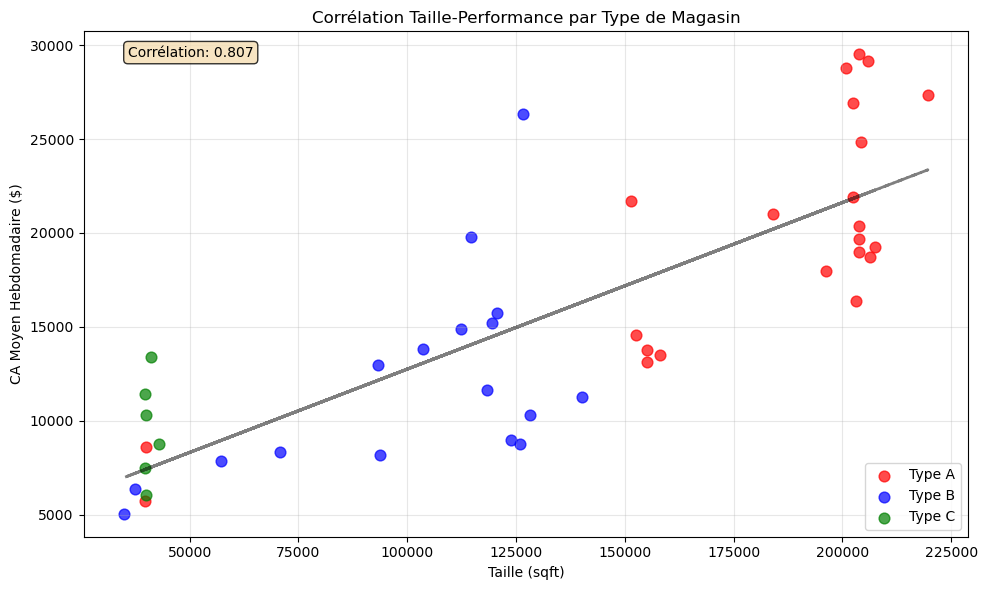

In [30]:
# Graphique Taille vs Performance
query_taille_perf = """
SELECT 
    sa.Store,
    s.Size,
    s.Type,
    ROUND(AVG(sa.Weekly_Sales), 2) AS CA_Moyen
FROM sales sa
JOIN stores s ON sa.Store = s.Store
GROUP BY sa.Store, s.Size, s.Type;
"""

taille_perf = pd.read_sql(query_taille_perf, conn)

plt.figure(figsize=(10, 6))
colors = {'A': 'red', 'B': 'blue', 'C': 'green'}

for store_type in taille_perf['Type'].unique():
    data = taille_perf[taille_perf['Type'] == store_type]
    plt.scatter(data['Size'], data['CA_Moyen'], 
               alpha=0.7, color=colors[store_type], label=f'Type {store_type}', s=60)

plt.xlabel('Taille (sqft)')
plt.ylabel('CA Moyen Hebdomadaire ($)')
plt.title('Corrélation Taille-Performance par Type de Magasin')
plt.legend()
plt.grid(True, alpha=0.3)

# Ligne de tendance
z = np.polyfit(taille_perf['Size'], taille_perf['CA_Moyen'], 1)
p = np.poly1d(z)
plt.plot(taille_perf['Size'], p(taille_perf['Size']), "k--", alpha=0.5, linewidth=2)

# Corrélation
correlation = taille_perf['Size'].corr(taille_perf['CA_Moyen'])
plt.text(0.05, 0.95, f'Corrélation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

correlation = taille_perf['Size'].corr(taille_perf['CA_Moyen'])

**Corrélation Confirmée**

Relation taille-performance validée visuellement.

## Heatmaps Performance Départements par Type

Visualisation des performances départementales pour chaque type de magasin.

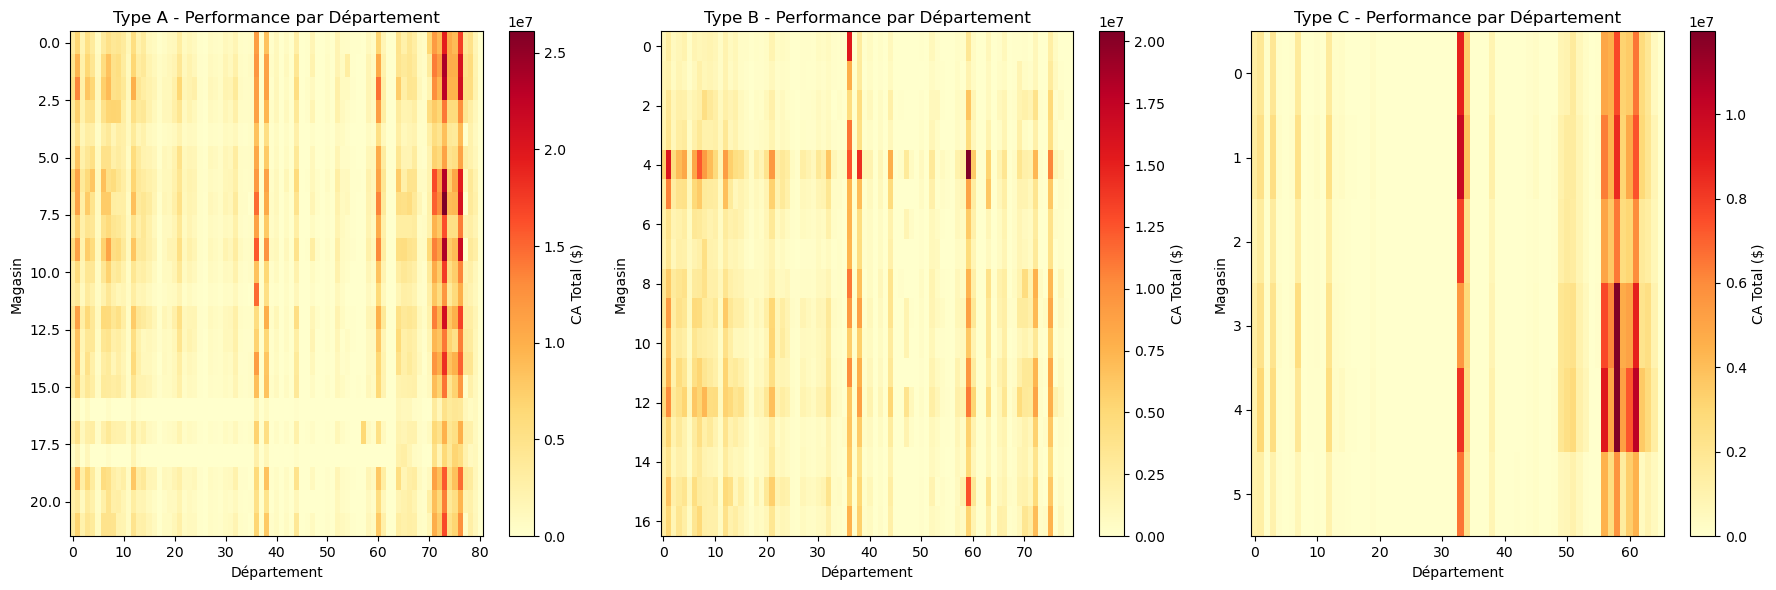

→ Heatmaps générées pour analyse visuelle par type
→ Patterns de performance différents selon le type de magasin


In [31]:
# Préparation données pour heatmaps
query_heatmap = """
SELECT 
    s.Type,
    sa.Store,
    sa.Dept,
    ROUND(SUM(sa.Weekly_Sales), 2) AS CA_Total
FROM sales sa
JOIN stores s ON sa.Store = s.Store
GROUP BY s.Type, sa.Store, sa.Dept;
"""

heatmap_data = pd.read_sql(query_heatmap, conn)

# Création des heatmaps pour chaque type
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, store_type in enumerate(['A', 'B', 'C']):
    type_data = heatmap_data[heatmap_data['Type'] == store_type]
    
    if len(type_data) > 0:
        # Pivot pour la heatmap
        pivot_data = type_data.pivot(index='Store', columns='Dept', values='CA_Total')
        pivot_data = pivot_data.fillna(0)
        
        # Heatmap
        im = axes[i].imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        
        axes[i].set_title(f'Type {store_type} - Performance par Département')
        axes[i].set_xlabel('Département')
        axes[i].set_ylabel('Magasin')
        
        # Colorbar
        plt.colorbar(im, ax=axes[i], label='CA Total ($)')

plt.tight_layout()
plt.show()

print("→ Heatmaps générées pour analyse visuelle par type")
print("→ Patterns de performance différents selon le type de magasin")

## Graphique temporel par type

In [32]:

# Couleurs pour chaque type
colors = {'A': '#FF6B6B', 'B': '#4ECDC4', 'C': '#45B7D1'}

fig3 = px.line(
    type_pivot_result, 
    x="Nom_Mois", 
    y=["Type_A","Type_B","Type_C"], 
    title="CA Hebdomadaire par Type de Magasin",
    markers=True,
    color_discrete_sequence=[colors['A'], colors['B'], colors['C']]
)
# Augmenter l'épaisseur des lignes
fig3.update_traces(line_width=3.5)


fig3.show()

## Graphique temporel des départements

In [ ]:
# Graphique temporel pour les top 10 départements saisonniers

# Récupération dynamique de la liste des 10 départements avec plus forte variation saisonnière
query_get_top10 = """
WITH dept_stats AS (
    SELECT 
        sa.Dept,
        ROUND(SUM(CASE WHEN CAST(strftime('%m', sa.Date) as INTEGER) = 12 THEN sa.Weekly_Sales ELSE 0 END) / 
              NULLIF(COUNT(CASE WHEN CAST(strftime('%m', sa.Date) as INTEGER) = 12 THEN 1 END), 0), 2) as CA_Moyen_Hebdo_Decembre,
        ROUND(SUM(sa.Weekly_Sales) / COUNT(*), 2) as CA_Moyen_Hebdo_Annee
    FROM sales sa
    JOIN stores s ON sa.Store = s.Store
    WHERE s.Type = 'A'
    GROUP BY sa.Dept
),
ranked_stats AS (
    SELECT 
        Dept,
        ROW_NUMBER() OVER (ORDER BY (CA_Moyen_Hebdo_Decembre - CA_Moyen_Hebdo_Annee) DESC) as rang_desc
    FROM dept_stats
    WHERE CA_Moyen_Hebdo_Annee IS NOT NULL
)
SELECT Dept
FROM ranked_stats
WHERE rang_desc <= 10
ORDER BY rang_desc;
"""

top_depts_df = pd.read_sql(query_get_top10, conn)
top_depts = top_depts_df['Dept'].tolist()
print("Top 10 des départements utilisés pour le graphique:", top_depts)

# Requête pour récupérer les données temporelles de ces départements
query_top_depts = f"""
WITH dept_monthly AS (
    SELECT 
        Dept,
        CAST(strftime('%m', Date) as INTEGER) as Mois,
        ROUND(SUM(Weekly_Sales) / COUNT(*), 2) as CA_Moyen_Hebdo,
        CASE CAST(strftime('%m', Date) as INTEGER)
            WHEN 1 THEN 'Jan' WHEN 2 THEN 'Fév' WHEN 3 THEN 'Mar'
            WHEN 4 THEN 'Avr' WHEN 5 THEN 'Mai' WHEN 6 THEN 'Jun'
            WHEN 7 THEN 'Jul' WHEN 8 THEN 'Aoû' WHEN 9 THEN 'Sep'
            WHEN 10 THEN 'Oct' WHEN 11 THEN 'Nov' WHEN 12 THEN 'Déc'
        END as Nom_Mois
    FROM sales
    WHERE Dept IN ({','.join(map(str, top_depts))})
    GROUP BY Dept, strftime('%m', Date)
)
SELECT 
    Mois,
    Nom_Mois,
    {','.join([f"SUM(CASE WHEN Dept = {dept} THEN CA_Moyen_Hebdo END) as Dept_{dept}" for dept in top_depts])}
FROM dept_monthly
GROUP BY Mois, Nom_Mois
ORDER BY Mois;
"""

dept_temporal_data = pd.read_sql(query_top_depts, conn)

# Colonnes des départements pour le graphique
dept_columns = [f'Dept_{dept}' for dept in top_depts]

# Palette de couleurs distinctives
colors_depts = [
    '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
    '#DDA0DD', '#98D8C8', '#FDCB6E', '#6C5CE7', '#A29BFE'
]

# Création du graphique
fig_depts = px.line(
    dept_temporal_data, 
    x="Nom_Mois", 
    y=dept_columns,
    title="<b>Évolution Saisonnière des Top 10 Départements (Plus forte variation en Décembre - Type A)</b>",
    markers=True,
    color_discrete_sequence=colors_depts
)

fig_depts.show()
